# Statistical Analysis of fMRI Data

This section covers the fundamentals of statistical analysis in fMRI data, including creating a design matrix, fitting a general linear model (GLM), contrasts, and multiple comparison corrections.

## About This Data Set

This data set is a single *run* of a functional MRI (fMRI) experiment. A run is a continuous acquisition of fMRI data while a subject performs a task or rests. Typically runs last from 5 to 15 minutes. In this example, an adult human viewed many small dots shown in white on a black background. In alternating *blocks* of 20 s each, these dots either moved from the centre of the screen outward (motion condition) or remained stationary (baseline condition). During the motion blocks, the participant was instructed to press a button with their right index finger whenever they saw the dots speed up briefly (which happened at random intervals). During the stationary (baseline) blocks, the participant was instructed to press the button whenever the dots dmiied briefly (which also happened at random intervals).

The purpose of this task was to identify, or *localize*, brain regions involved in processing visual motion. Localizer tasks are commonly used in fMRI research to identify specific brain regions of interest (ROIs) based on specific response properties (in this case, sensitivity to visual motion). Often this will be used to test smore specific hypotheses about the response properties of a particular area, or how it might interact with other brain regions during more complex tasks. For the present example, we will focus on identifying the well-known human MT+ complex (or V5), a region in the lateral occipital cortex that is strongly selective for visual motion.

The goal of the analysis is to identify brain regions that are more active during the motion blocks compared to the baseline blocks.

### fMRI Preprocessing

Before performing statistical analysis on fMRI data, it is essential to preprocess the data to correct for various artifacts and prepare it for analysis. Common preprocessing steps include:
- **Motion Correction**: Aligning all fMRI volumes to a reference volume to correct for head movements during the scan.
- **Slice Timing Correction**: Adjusting for differences in acquisition time between slices in a volume.
- **Spatial Normalization**: Transforming the fMRI data into a standard anatomical space (e.g., MNI space) to allow for group analysis and comparison across subjects.
- **Smoothing**: Applying a spatial filter to the data to increase the signal-to-noise ratio and account for anatomical variability across subjects.  

However, for simplicity here we will use preprocessed data that has already undergone motion correction and spatial normalization using established neuroimaging software (FSL). This allows us to focus on the statistical analysis aspects without getting bogged down in preprocessing details.

:::{note}
The software ecosystem in Python for fMRI preprocessing and analysis at this point in time is actually a realtively underdeveloped, especially compared to libraries like MNE (which we used in the EEG chapter). Most of the software development in the fMRI field has been done outside of Python, including in Matlab (e.g., SPM) and C (e.g., AFNI, FSL). There are also more sophisticated pipeline builders like fMRIprep that allow the user to define a series of preprocessing and analysis steps that may employ different functions from different software packages. This allows researchers to use their choice of tools for specific steps in the pipeline, and do it via one common syntax. However, this is not in Python and thus outside the scope of this book.
:::

In [1]:
# Import all required libraries
from bids import BIDSLayout
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
from nilearn.plotting import plot_anat, show, plot_design_matrix, plot_stat_map
from nilearn.image import math_img
from nilearn.reporting import get_clusters_table

import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

## Introducing BIDS
The Brain Imaging Data Structure (BIDS) is a standardized way to organize and describe neuroimaging data. It simplifies data sharing and analysis by providing a consistent structure. BIDS is not a file format; rather it is a set of conventions for organizing and describing data. The intent of BIDS is to make it easier for researchers to share, analyze, and reproduce neuroimaging studies. By organizing data in a standardized way, BIDS facilitates collaboration and enhances the reproducibility of neuroimaging research. It can also facilitate the use of automated analysis pipelines that expect data to be organized in a specific way. This not only makes it easier for invidual labs to manage their data and analysis pipelines, but also promotes best practices in data management across the neuroimaging community. It has become standard practice in the neuroimaging community to share data in BIDS format whenever possible, for example via platforms like [OpenNeuro](https://openneuro.org). OpenNeuro requires datasets to be BIDS-compliant before they can be shared on the platform. Nto only does this ensure that datasets are well-organized and easy to understand, but it also makes it easier for other researchers to apply different analysis methods to the same dataset. It also facilitates aggregation of research results; for example it would be quite easy to implement a meta-analysis across multiple studies if they were all BIDS-compliant. 

### BIDS Directory Structure

The data used in this example is organized in BIDS format. The directory structure looks like this:

```
data/BIDS/
├── dataset_description.json     # Dataset metadata
├── participants.tsv             # Participant information
├── participants.json            # Participant data dictionary
├── README                       # Dataset documentation
├── task-MotionLoc_bold.json    # Task-specific metadata for BOLD
├── task-MotionLoc_events.json  # Task-specific events metadata
├── code/                        # Analysis code
│   └── convert_design_to_events.py
└── sub-001/                     # Subject 001
    └── ses-01/                  # Session 01
        ├── anat/                # Anatomical data
        │   ├── sub-001_ses-01_task-MotionLoc_T1w.nii.gz  # T1-weighted image
        │   └── sub-001_ses-01_task-MotionLoc_T1w.json    # T1 metadata
        └── func/                # Functional data
            ├── sub-001_ses-01_task-MotionLoc_bold.nii.gz    # BOLD fMRI
            ├── sub-001_ses-01_task-MotionLoc_bold.json      # BOLD metadata
            └── sub-001_ses-01_task-MotionLoc_events.tsv     # Stimulus events
```

There are a few key features of BIDS organization to note:
- **Hierarchical structure**: Dataset → Subject → Session → Data type
- **Standardized naming**: Files follow the pattern `sub-<label>_ses-<label>_task-<label>_<suffix>.<extension>`
- **Metadata files**: JSON files contain acquisition parameters and other metadata
- **Events files**: TSV files describe stimulus timing and experimental conditions
- **Documentation**: README and dataset_description.json provide dataset-level information

In this example, we will use a BIDS-formatted dataset to demonstrate fMRI data analysis. We'll start with the [`PyBIDS` ](https://github.com/bids-standard/pybids) library for Python.

## Read the BIDS Structure

First, we need to read the BIDS structure to access our fMRI data. We'll use the `bids` library for this purpose.


In [2]:
# Initialize BIDS layout (validate=False skips full validation for speed)
layout = BIDSLayout('./data/BIDS', validate=False)

# Display dataset info
print(f"Dataset: {layout.description['Name']}")
print(f"Subjects: {layout.get_subjects()}")
print(f"Tasks: {layout.get_tasks()}")
print(f"Sessions: {layout.get_sessions()}")

Dataset: Visual Motion Localizer fMRI Dataset
Subjects: ['001']
Tasks: ['MotionLoc']
Sessions: ['01']


## Read the fMRI Data

Next, we will read the fMRI data from the BIDS structure. We will use the `.get()` method on the BIDS layout object we obtained above, to get the path to the BOLD fMRI NIfTI file, and then use the `nibabel` library to load the NIfTI files. 

```python

In [3]:
# Get functional BOLD data for subject 001
bold_file = layout.get(subject='001', session='01', task='MotionLoc',
                       suffix='bold', extension='.nii.gz')[0]

# Load the BOLD data
bold_img = image.load_img(bold_file.path)

## Vizualize the fMRI Data

It's always good to visualize your data and do some other validation checks when you first open an image. This way, you can ensure that the data has been read correctly and is in the expected format.

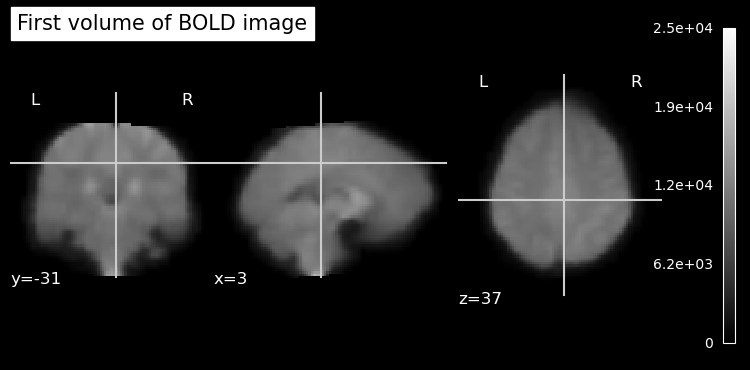

In [4]:
# plot an ortho view of the BOLD image

# Temporarily set figure size to be 25% wider
plt.rcParams['figure.figsize'] = [12.5, 10]
plot_anat(bold_img.slicer[:, :, :, 0], title='First volume of BOLD image')
show()

## Read fMRI Header Information

Nifti files contain header information that provides metadata about the image, such as voxel dimensions, data type, and orientation. We can access this information using the `nibabel` library. 

In [5]:
# show nifti header
print(bold_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 16384
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  4  91 109  91 103   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  2.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'2203.12-dirty 2024-02-01T16:17:47+00:00')
aux_file        : np.bytes_(b'')
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.

## View dimensions and voxel size

The Nifti header contains a lot of information. Let's pull out specifically the voxel dimensions, and the number of voxels in each plane of the image. 



In [6]:
# read bold image header using nibabel
# Get voxel dimensions and shape from the BOLD image
voxel_dimensions = bold_img.header.get_zooms()
num_voxels = bold_img.header.get_data_shape()

print(f"Voxel Dimensions: {voxel_dimensions[0]:.1f} x {voxel_dimensions[1]:.1f} x {voxel_dimensions[2]:.1f} mm")
print(f"TR: {voxel_dimensions[3]:.1f} seconds")
print(f"Number of Voxels in each plane: {num_voxels}")

Voxel Dimensions: 2.0 x 2.0 x 2.0 mm
TR: 2.0 seconds
Number of Voxels in each plane: (91, 109, 91, 103)


You'll notice in the output that the fourth dimension corresponds to the TR (repetition time) of the fMRI scan, which is the time between successive volume acquisitions. This is important for understanding the temporal resolution of your fMRI data. It also explains why fMRI data is often represented as a 4D dataset, with three spatial dimensions and one temporal dimension. In the output above, the 4th value listed in the "Number of Voxels in each plane" corresponds to the number of time points (or volumes) acquired during the fMRI scan.

## Load Structural (Anatomical) Image

In [7]:
# load anatomical image
anat_file = layout.get(subject='001', session='01',
                      suffix='T1w', extension='.nii.gz')[0]
anat_img = image.load_img(anat_file.path)
print(f"Anatomical image shape: {anat_img.shape}")

voxel_dims = anat_img.header.get_zooms()
print(f"Voxel Dimensions: {voxel_dims[0]:.1f} x {voxel_dims[1]:.1f} x {voxel_dims[2]:.1f} mm")

Anatomical image shape: (91, 109, 91)
Voxel Dimensions: 2.0 x 2.0 x 2.0 mm


Since the anatomical image is strrctural, there is only one volume so it's a 3D image with no time dimension. You'll also notice that the voxel dimensions are different between the anatomical and functional images. Anatomical images typically have higher spatial resolution than functional images. Since the voxels are smaller, more of them are required to cover the same brain volume. 

## Plot Anatomical Image

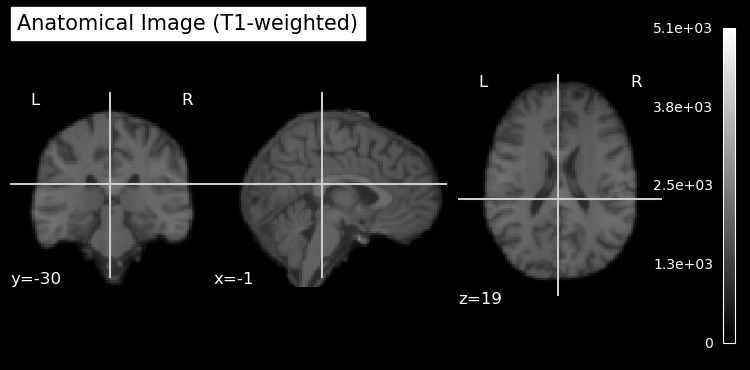

In [8]:
# plot anatomical image
plt.rcParams['figure.figsize'] = [12.5, 10]
plot_anat(anat_img, title='Anatomical Image (T1-weighted)')
show()

Note that the anatomical image has been *skull stripped* to remove non-brain tissue. This is a common preprocessing step in neuroimaging to focus analyses on brain tissue only. It also helps anonymize the data by removing identifiable features such as the face and skull. As is sometimes the case, the skull stripping was not perfect, and some non-brain tissue can be seen at the top of the head in the sagittal view.

## Read Events File

The events file contains information about the timing and type of stimuli presented during the fMRI scan. We will read this file using `pandas`.

In [9]:
# Get events file
events_file = layout.get(subject='001', session='01', task='MotionLoc',
                        suffix='events', extension='.tsv')[0]

# Load events as DataFrame
events_df = pd.read_csv(events_file.path, sep='\t')

print(f"\nEvents (first few rows):")
print(events_df.head())


Events (first few rows):
   onset  duration trial_type
0    6.0      20.0     motion
1   46.0      20.0     motion
2   86.0      20.0     motion
3  126.0      20.0     motion
4  166.0      20.0     motion


This shows us that there is only one type of event: `motion`. In this block design, blocks of moving dot stimuli alternatied with blocks of static dot stimuli. However, since there are only two conditions (motion and static), we can model the static condition as the baseline (intercept) in our design matrix. This means we don't need to explicitly include it as a separate regressor in our model; rather, the baseline is inferred from the absence of any explicitly-defined event occurring at a given time point.

## The Design Matrix

The design matrix represents the experimental conditions and is used in the GLM analysis. At first it may seem confusing, but it's essentially a way to encode when different stimuli were presented during the fMRI scan. This is used in the statistical analysis to essentially perform a correlation (regression) between the BOLD time series at each voxel in the image, and the time series that would be predicted for brain areas that are sensitive to the experimental conditions. 

In our simple moving/not moving block design, this means we want to correlate the data at each voxel with a time series that is high during blocks of moving dots, and low during blocks of static dots. This is often called a boxcar design. Let's draw this boxcar design using matplotlib and the event timings in `events_df`:

:::{admonition} Hidden code
The code that generates this plot (and a few after it) is hidden to reduce clutter. The focus of this lesson is on GLM analysis, not how to generate these plots. If you want to view the code, click on "Source" at the top of each cell.
:::

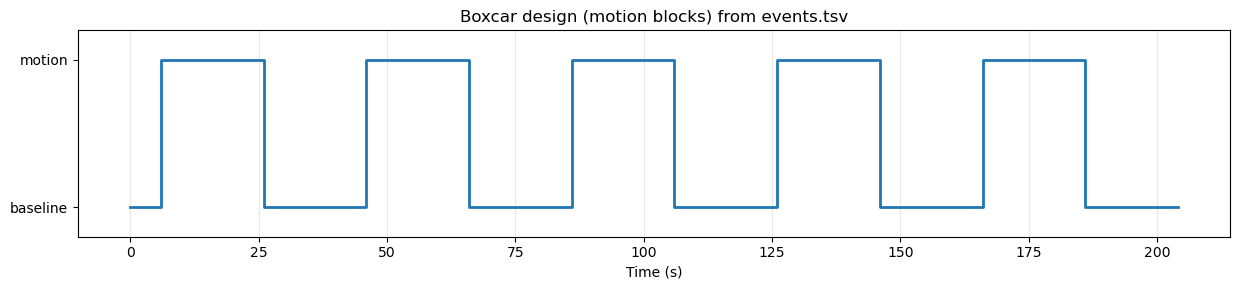

In [10]:
# Create and plot a boxcar (square-wave) design from events_df

# Derive timing grid from the BOLD image
tr_sec = float(bold_img.header.get_zooms()[3])  # seconds per volume
n_scans = int(bold_img.shape[-1])
frame_times = np.arange(n_scans) * tr_sec

# Build a binary regressor that's 1 during motion blocks, 0 otherwise
boxcar = np.zeros_like(frame_times, dtype=float)
for _, row in events_df.iterrows():
    onset = float(row['onset'])
    duration = float(row['duration'])
    # Mark frames whose time falls within the event window
    idx = (frame_times >= onset) & (frame_times < onset + duration)
    boxcar[idx] = 1.0

# Plot as a step function (square wave)
plt.figure(figsize=(12.5, 3.0))
plt.step(frame_times, boxcar, where='post', linewidth=2)
plt.ylim(-0.2, 1.2)
plt.yticks([0, 1], ['baseline', 'motion'])
plt.xlabel('Time (s)')
plt.title('Boxcar design (motion blocks) from events.tsv')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()

### Modelling the Hemodynamic Response Function (HRF)

Although our experimental design is a simple boxcar design, the BOLD response in the brain does not follow this boxcar shape exactly. Instead, the BOLD response is delayed and smoothed due to the hemodynamic response function (HRF), which describes how blood flow changes in response to neural activity. There are several models of the HRF, but a common one is the `glover` model, originally described by Gary Glover in 1999. This model posits that the HRF in response to a transient (short) neural event can be described by a relatively simple mathematical function that captures the key features of the BOLD response, including its initial rise, peak, and subsequent undershoot. If we plot the Glover HRF it looks like this:


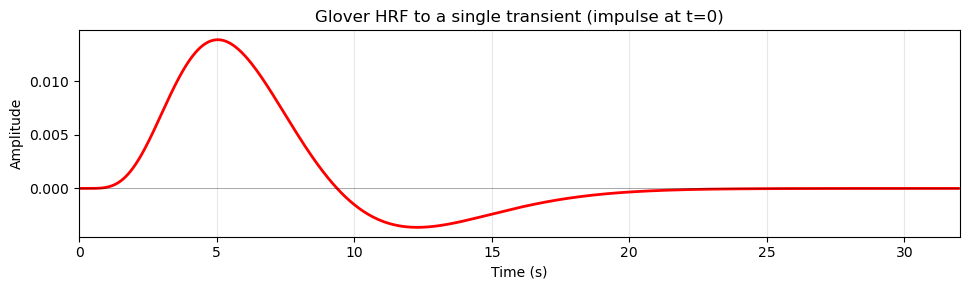

In [11]:
# Plot the Glover HRF response to a single transient (impulse at t=0)

# Use TR from the functional image
tr_sec = float(bold_img.header.get_zooms()[3])

# High-resolution HRF sampling
oversampling = 50
time_length = 32.0  # seconds

# Updated parameter name: use t_r instead of deprecated tr
hrf = glover_hrf(t_r=tr_sec, oversampling=oversampling, time_length=time_length, onset=0)

dt = tr_sec / oversampling
t = np.arange(0, time_length, dt)

plt.figure(figsize=(10, 3))
plt.plot(t, hrf, color='red', linewidth=2)
plt.axhline(0, color='k', linewidth=0.6, alpha=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Glover HRF to a single transient (impulse at t=0)')
plt.xlim(0, time_length)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Note that the HRF does not start right at time zero (when the stimulus occurred), but has a delay of about 2 seconds before it starts to rise. This delay reflects the time it takes for capillaries to dilate in response to changes in nneural activity, and allow more blood to flow to the area. The HRF peaks around 5-6 seconds after the neural event and then gradually returns to baseline, often dipping below baseline (undershoot) before stabilizing.

Because of this delayed and smoothed response, we cannot simply use the boxcar design as our regressor in the GLM analysis. Technically we could, but the correlation to the actual BOLD response would be much weaker, since the BOLD response does not follow the boxcar shape exactly. Instead, we need to account for the HRF when creating our design matrix. We do this using a mathematical operation called convolution. Convolution essentially "smears" the boxcar design by the shape of the HRF (imagine the HRF shown above sliding in time from left to right over the boxcar plot), resulting in a regressor that more closely matches the expected BOLD response to the stimuli.


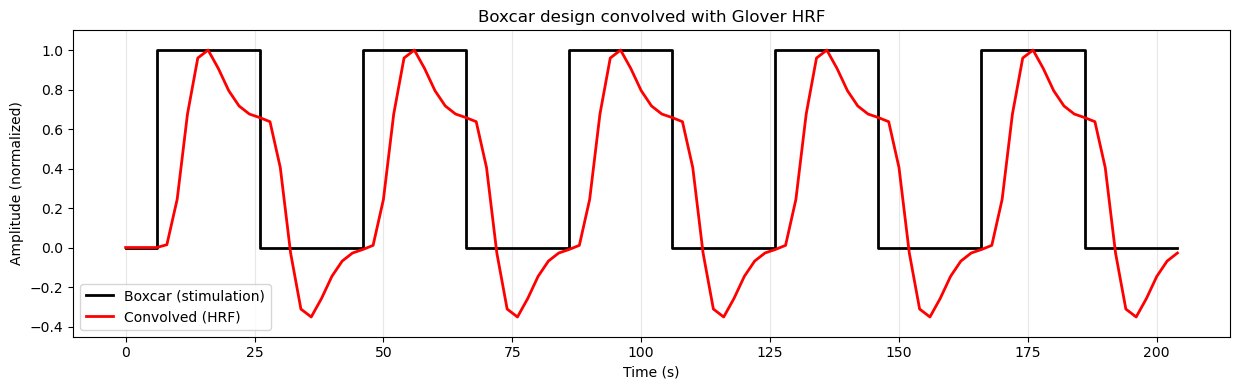

In [12]:
# Convolve boxcar design with Glover HRF and plot

# Recreate frame_times and boxcar (reuse variables if they exist)
tr_sec = float(bold_img.header.get_zooms()[3])
n_scans = int(bold_img.shape[-1])
frame_times = np.arange(n_scans) * tr_sec

if 'boxcar' not in globals():
    boxcar = np.zeros_like(frame_times, dtype=float)
    for _, row in events_df.iterrows():
        onset = float(row['onset'])
        duration = float(row['duration'])
        idx = (frame_times >= onset) & (frame_times < onset + duration)
        boxcar[idx] = 1.0

# Oversampled time grid for more accurate convolution
oversampling = 50
time_length = frame_times[-1] + tr_sec  # cover full duration
hrf = glover_hrf(t_r=tr_sec, oversampling=oversampling, time_length=32.0, onset=0)

# Build an oversampled neural (boxcar) vector
dt = tr_sec / oversampling
high_res_time = np.arange(0, time_length, dt)
high_res_neural = np.zeros_like(high_res_time)
for _, row in events_df.iterrows():
    onset = float(row['onset'])
    duration = float(row['duration'])
    idx = (high_res_time >= onset) & (high_res_time < onset + duration)
    high_res_neural[idx] = 1.0

# Convolve and trim
conv_high_res = np.convolve(high_res_neural, hrf)[:high_res_neural.size]

# Downsample back to scan times
conv_regressor = []
for t in frame_times:
    # pick closest high-res index
    idx = int(round(t / dt))
    if idx >= conv_high_res.size:
        idx = conv_high_res.size - 1
    conv_regressor.append(conv_high_res[idx])
conv_regressor = np.array(conv_regressor)

# Normalize for visual comparison (optional)
if conv_regressor.max() > 0:
    conv_norm = conv_regressor / conv_regressor.max()
else:
    conv_norm = conv_regressor

plt.figure(figsize=(12.5, 4))
plt.step(frame_times, boxcar, where='post', label='Boxcar (stimulation)', linewidth=2, color='black')
plt.plot(frame_times, conv_norm, label='Convolved (HRF)', linewidth=2, color='red')

# Dynamic y-limits so negative undershoot isn't cropped
ymin = min(conv_norm.min(), boxcar.min()) - 0.1
ymax = max(conv_norm.max(), boxcar.max()) + 0.1
plt.ylim(ymin, ymax)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.title('Boxcar design convolved with Glover HRF')
plt.legend(loc='lower left')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Regressors in the Design Matrix

### Experimental Regressors
Whe we create the desgn matrix, we use the HRF model to convolve our time series this way. In this simple example, we only have one condition (motion), so our design matrix will have one regressor for the motion condition. However, in a more complex design with multiple conditions, we would have multiple regressors (time series), one for each condition.

### Nuisance Regressors
The design matrix also includes other regressors, such as an intercept term (constant) to model the baseline signal, and potentially other nuisance regressors to account for confounding factors.

 The intercept is necessary because the general linear model (GLM), which we use to analyze fMRI data, is an extension of the simple formula for a line that you likely learned in school: `y = mx + b`. In this formula, 'b' represents the y-intercept, which is the value of 'y' when 'x' is zero. In the context of fMRI data analysis, the intercept represents the baseline level of the BOLD signal when no experimental conditions are present (or in this case, when the dots on the screen were not moving).

In addition to the intercept, we often include other *nuisance regressors* in the design matrix to account for confounding factors that can influence the BOLD signal but are not of primary interest in our analysis. BOLD data is known to contain drift (meaning that the signal can slowly change over time) due to scanner instability or physiological factors. It may also contain low-frequency (slowly changing over time) noise due to physilogical processes such as respiration and heart rate. To account for these confounding factors, we can include nuisance regressors in our design matrix that model these effects. The simplest way to do this is to include polynomial trends (e.g., linear, quadratic) to model drift, and potentially other regressors derived from physiological recordings (if available) to model physiological noise.

Other examples of nuisance regressors include motion parameters (to account for head movement during the scan), and physiological signals (e.g., heart rate, respiration if they were recorded along with the fMRI data). Including these nuisance regressors helps to improve the accuracy and reliability of our statistical analysis by reducing the influence of these confounding factors on the estimated effects of our experimental conditions. However, in the present example we will keep it simple and only include the intercept and polynomial terms.

All of the regressors in our design matrix look like this:


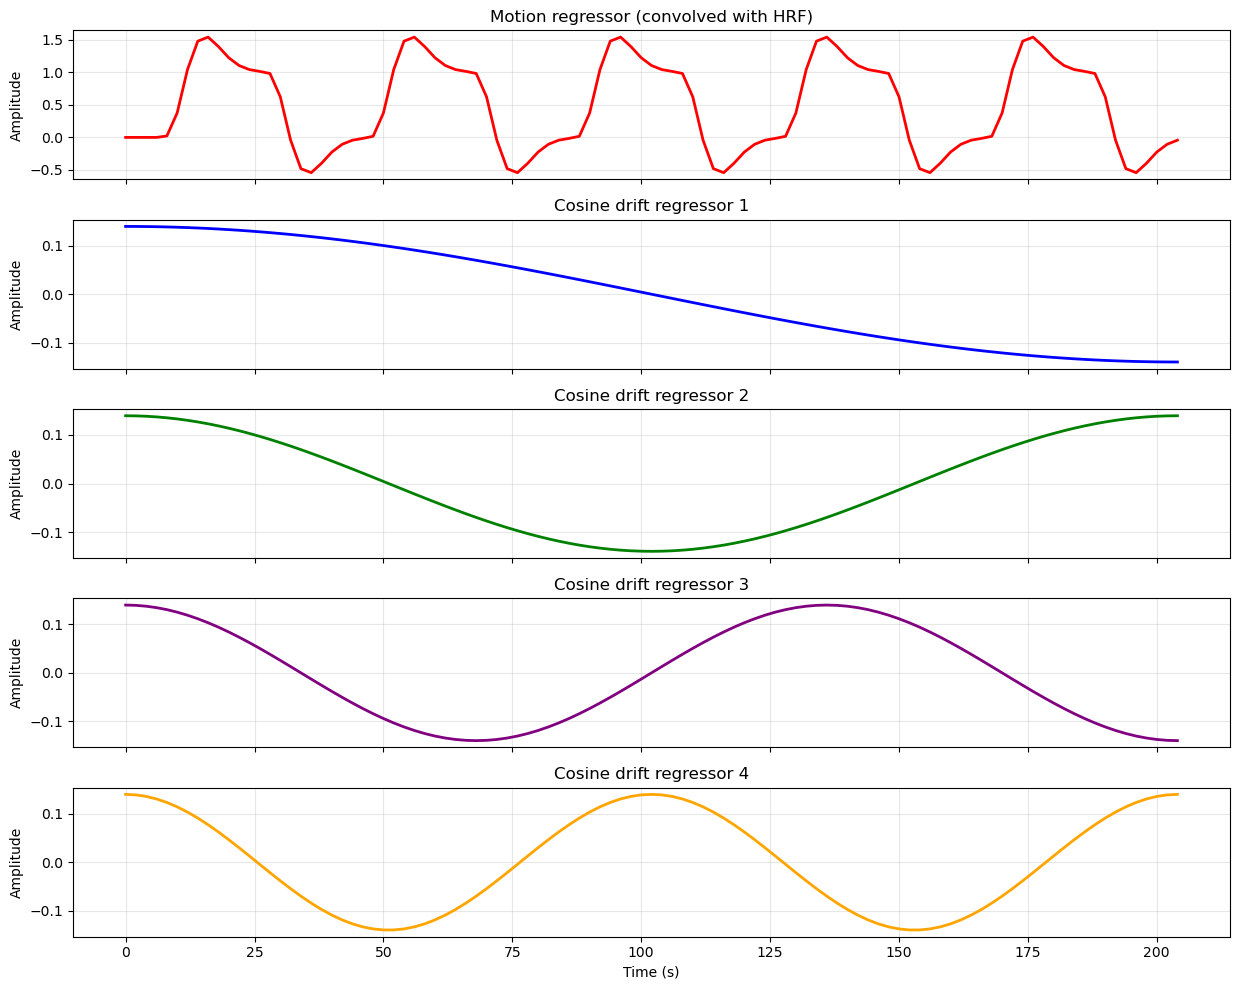

In [13]:
# Plot example regressors that would be in a design matrix

# Recreate frame_times if needed
tr_sec = float(bold_img.header.get_zooms()[3])
n_scans = int(bold_img.shape[-1])
frame_times = np.arange(n_scans) * tr_sec

# Generate the motion regressor by convolving boxcar with HRF
# (same approach as earlier cell)
if 'boxcar' not in globals():
    boxcar = np.zeros_like(frame_times, dtype=float)
    for _, row in events_df.iterrows():
        onset = float(row['onset'])
        duration = float(row['duration'])
        idx = (frame_times >= onset) & (frame_times < onset + duration)
        boxcar[idx] = 1.0

# Oversampled convolution
oversampling = 50
time_length = frame_times[-1] + tr_sec
hrf = glover_hrf(t_r=tr_sec, oversampling=oversampling, time_length=32.0, onset=0)

dt = tr_sec / oversampling
high_res_time = np.arange(0, time_length, dt)
high_res_neural = np.zeros_like(high_res_time)
for _, row in events_df.iterrows():
    onset = float(row['onset'])
    duration = float(row['duration'])
    idx = (high_res_time >= onset) & (high_res_time < onset + duration)
    high_res_neural[idx] = 1.0

conv_high_res = np.convolve(high_res_neural, hrf)[:high_res_neural.size]

# Downsample to scan times
motion_regressor = []
for t in frame_times:
    idx = int(round(t / dt))
    if idx >= conv_high_res.size:
        idx = conv_high_res.size - 1
    motion_regressor.append(conv_high_res[idx])
motion_regressor = np.array(motion_regressor)

# Create cosine drift regressors manually
# High-pass filter at 0.01 Hz (matching the design matrix creation)
high_pass = 0.01

# Calculate number of cosine basis functions based on high-pass frequency
# This matches nilearn's approach
n_times = len(frame_times)
duration = frame_times[-1]
order = int(np.floor(2 * duration * high_pass))

# Generate cosine basis functions
cosine_drift = np.zeros((n_times, order))
normalizer = np.sqrt(2.0 / n_times)

for k in range(order):
    cosine_drift[:, k] = normalizer * np.cos((np.pi / duration) * (k + 1) * (frame_times - frame_times[0]))

# Get first 4 cosine basis functions
n_cosines = min(4, cosine_drift.shape[1])

# Create figure with subplots (motion + cosine basis functions)
fig, axes = plt.subplots(n_cosines + 1, 1, figsize=(12.5, 10), sharex=True)

# Colors for each regressor
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot 1: Motion regressor (convolved with HRF)
axes[0].plot(frame_times, motion_regressor, color=colors[0], linewidth=2)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Motion regressor (convolved with HRF)')
axes[0].grid(True, alpha=0.3)

# Plot cosine basis functions
for i in range(n_cosines):
    axes[i+1].plot(frame_times, cosine_drift[:, i], color=colors[i+1], linewidth=2)
    axes[i+1].set_ylabel('Amplitude')
    axes[i+1].set_title(f'Cosine drift regressor {i+1}')
    axes[i+1].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

### Create the Design Matrix

In practice, we don't need to generate all of the plots above or write code to implement any of the computations used to create them. This is all done by `nilearn`'s `make_first_level_design_matrix` function. 

This function requires a number of inputs: the frame times (time points corresponding to each volume in the fMRI data), the events dataframe, the repetition time (TR), and the type of HRF model to use. It also allows us to specify additional parameters, such as the degree of polynomial trends to include as nuisance regressors. It also allows us to apply a high-pass filter to the data, which is an additional way to remove low-frequency noise.

In [14]:
# create design matrix

frame_times = np.arange(bold_img.shape[-1]) * voxel_dimensions[3]

design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_df,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01
)

print("Design Matrix (first 10 rows):")
print(design_matrix.head(10))

Design Matrix (first 10 rows):
        motion   drift_1   drift_2   drift_3   drift_4  constant
0.0   0.000000  0.139330  0.139282  0.139201  0.139087       1.0
2.0   0.000000  0.139201  0.138764  0.138036  0.137020       1.0
4.0   0.000000  0.138942  0.137729  0.135716  0.132915       1.0
6.0   0.000000  0.138553  0.136183  0.132261  0.126834       1.0
8.0   0.021881  0.138036  0.134129  0.127700  0.118868       1.0
10.0  0.376647  0.137390  0.131577  0.122069  0.109135       1.0
12.0  1.043051  0.136617  0.128535  0.115418  0.097779       1.0
14.0  1.480741  0.135716  0.125015  0.107801  0.084969       1.0
16.0  1.542614  0.134690  0.121030  0.099281  0.070897       1.0
18.0  1.397543  0.133538  0.116595  0.089932  0.055770       1.0


### Visualize the Design Matrix

We can plot the design matrix using conventional `matplotlib` functions. 

One thing that sometimes trips people up when first learning about design matrices is the orientation of the matrix. Conentionally, we plot time on the *x* axis of most plots. However, in the plot above, time is on the *y* axis: each column represents a regressor (predictor variable), and each row represents a time point (observation). This is the standard orientation for design matrices in fMRI analysis. One advantage is that if the run is long, time is not squeezed to fit the width of the window.

You can think of the colours in each column as representing the height of the corresponding regressor at each time point. Essentially, we've taken the plot above and rotated it so that we're viewing each line from above, rather than from the side. White represents the highest values, black the lowest, and shades of grey represent intermediate values. The last column is the intercept, which we didn't plot in the previous figure.

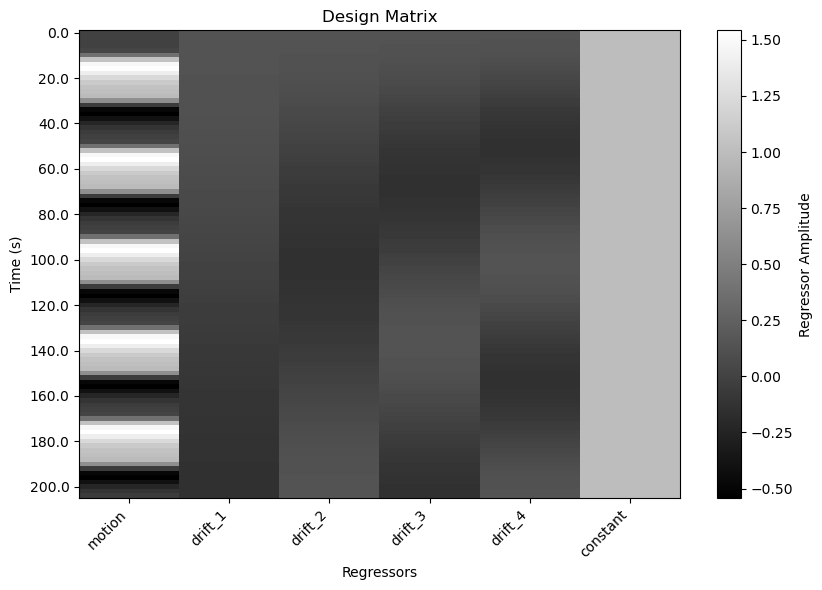

In [15]:
# plot design matrix, in grey scale
plt.figure(figsize=(8.5, 6))
plt.imshow(design_matrix, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar(label='Regressor Amplitude')
plt.yticks(ticks=np.arange(0, design_matrix.shape[0], step=10),
           labels=np.arange(0, design_matrix.shape[0], step=10) * voxel_dimensions[3])
plt.xticks(ticks=np.arange(design_matrix.shape[1]),
           labels=design_matrix.columns, rotation=45, ha='right')
plt.xlabel('Regressors')
plt.ylabel('Time (s)')
plt.title('Design Matrix')      
plt.tight_layout()
plt.show()

### Plot design matrix with `Nilearn`

`Nilearn` also provides a convenient function to plot the design matrix directly. 

:::{attention}The main downside to this function is that there is no kwarg to change the colour map. As discused in the chapter on plotting, a greyscale colour map is often better for visualizing matrices like this, since it avoids the perceptual distortions that can arise from using rainbow or other multi-colour maps.
:::

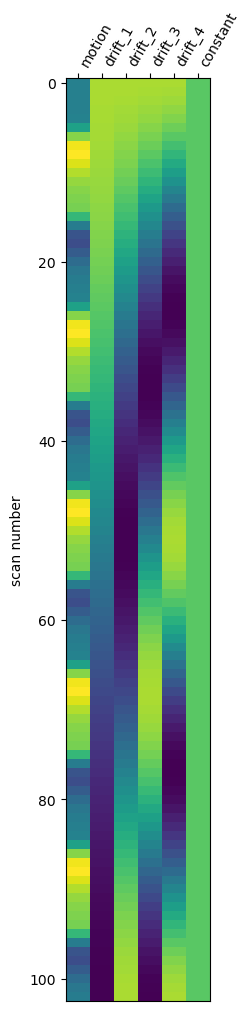

In [16]:
# plot design matrix using nilearn function
plot_design_matrix(design_matrix)  
plt.show()

## Run the GLM Analysis

To run the statistical analysis,we fit the design matrix to the time series from each voxel of the fMRI scan using the general linear model (GLM). To do this, we create an instance of the `FirstLevelModel` class from `nilearn`, specifying parameters including the repetition time (TR), which model of the HRF we want to use, and any smoothing to apply to the data. We then fit the model to the fMRI data and the design matrix, using the `.fit()` method provided by `FirstLevelModel`.

In [17]:
# run the GLM analysis
first_level_model = FirstLevelModel(hrf_model='glover', high_pass=0.01)
first_level_model = first_level_model.fit(bold_img, design_matrices=design_matrix)

## Compute and View Contrast

Recall from the design matrix that we are really only interested in the first column — the HRF-convolved model of our stimulus time series. All the other columns were nuisance regressors, meant to model variance that might otherwise make it more difficult for us to detect the effect of the stimulation. 

To view the results of the stimulation, we need to create a *contrast*. Contrasts can include comparisons between different columns, but in this case the contrast between moving and static dots was "built in" to the first regressor, since it modelled the motion blocks as "on" periods separated by "off" (static) periods. So in the code below we use a list comprehension to find the column containing the label `'motion'` (which was the label we gave it in the design matrix) and pass that to the the `.compute_contrast()` method, asking for *z* scores as output. 

Since *z* scores are standardized, they are easy to work with. In particular, any value of *z* is always associated with a specific value of *p*. Here we define a threshold of `z > 3.09`, which corresponds to a `p < .001` (one-tailed). 

```python>

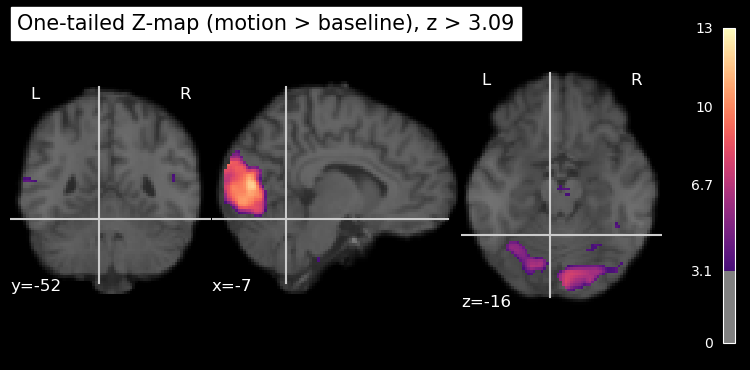

In [18]:
# Define one-tailed (positive) contrast for motion regressor
contrast_motion = np.array([1 if 'motion' in name else 0 for name in design_matrix.columns])

# Estimate contrast -> z map (positive values reflect motion > baseline)
z_map_motion = first_level_model.compute_contrast(contrast_motion, output_type='z_score')

# Mask: keep voxels where z > 3.09
z_thresh = 3.09

plt.rcParams['figure.figsize'] = [12.5, 10]
plot_stat_map(
    z_map_motion,
    bg_img=anat_img,
    threshold=z_thresh,
    vmin=0, # force only positive values
    cmap='magma',
    title='One-tailed Z-map (motion > baseline), z > 3.09'
)
show()

### Visualize MT+ Activation Maps

The crosshairs in the image above are automatically positioned, which is not always helpful. In this case, the crosshairs are positioned over the visual cortex, but not specifically over area MT+. We can manually set the crosshair positions to be over left and right MT+ using known coordinates from the literature. Since it ends up being a fair bit of code, and we're going to generate several plots like this, let's put the code into a function called `plot_mt_maps()`, which takes as input the *z*-map we computed above.

:::{note}
Spatial locations in MRI images are typically specified in MNI (Montreal Neurological Institute) space, which is a standardized coordinate system used in neuroimaging. The coordinates are provided as *x* (left-right), *Y* (front-back), and *z* (up-down) values in millimeters. The coordinate (0, 0, 0) is located near the anterior commissure, a small bundle of nerve fibers that connects the two hemispheres of the brain. Positive coordinate values indicate locations to the right (for *x*), front (for *Y*), and top (for *z*) of this point, while negative values indicate locations to the left, back, and bottom, respectively.
:::
```python

In [19]:
def plot_mt_maps(stat_map):
    """
    Plot statistical maps centered on left and right MT+ regions.
    
    Parameters
    ----------
    stat_map : Niimg-like object
        Statistical map to display (e.g., z-score map)
    """
    # define coordinates for L and R MT+
    # From Kolster, Peeters,  and Orban, 2010, J Neurosci
    # https://www.jneurosci.org/content/30/29/9801
    mt_coords = [(-48, -75, 8), (46, -78, 6)]
    
    # Create figure with two subplots side by side
    fig = plt.figure(figsize=(25, 20))
    
    # Left subplot - L MT+
    plt.subplot(2, 1, 1)
    display1 = plot_stat_map(
        stat_map,
        bg_img=anat_img,
        threshold=z_thresh,
        vmin=0, # force only positive values
        cmap='inferno',
        display_mode='ortho',
        cut_coords=mt_coords[0],
        title='One-tailed Z-map (motion > baseline), z > 3.09, L MT+',
        figure=fig,
        axes=plt.gca(),
        annotate=True
    )
    
    # Right subplot - R MT+
    plt.subplot(2, 1, 2)
    display2 = plot_stat_map(
        stat_map,
        bg_img=anat_img,
        threshold=z_thresh,
        vmin=0, # force only positive values
        cmap='inferno',
        display_mode='ortho',
        cut_coords=mt_coords[1],
        title='One-tailed Z-map (motion > baseline), z > 3.09, R MT+',
        figure=fig,
        axes=plt.gca(),
        annotate=True
    )
    
    # Increase font sizes for all text elements in the figure
    for ax in fig.get_axes():
        # Axis labels
        ax.xaxis.label.set_fontsize(24)
        ax.yaxis.label.set_fontsize(24)
        # Tick labels
        for label in ax.get_xticklabels():
            label.set_fontsize(20)
        for label in ax.get_yticklabels():
            label.set_fontsize(20)
        # Annotation text (coordinates, etc.)
        for text in ax.texts:
            text.set_fontsize(42)
    
    plt.tight_layout()
    show()

Now we can use that to plot the *z*-map we computed above.

:::{note}
The function throws a warning related to Matplotlib's `tight_layout()` feature. This warning can be safely ignored in this context, as it does not affect the functionality of the plotting – and the plots look better this way than without `tight_layout`.
:::

/var/folders/nq/chbqhzjx5hb6hfjx708rh2_40000gn/T/ipykernel_43853/519649290.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


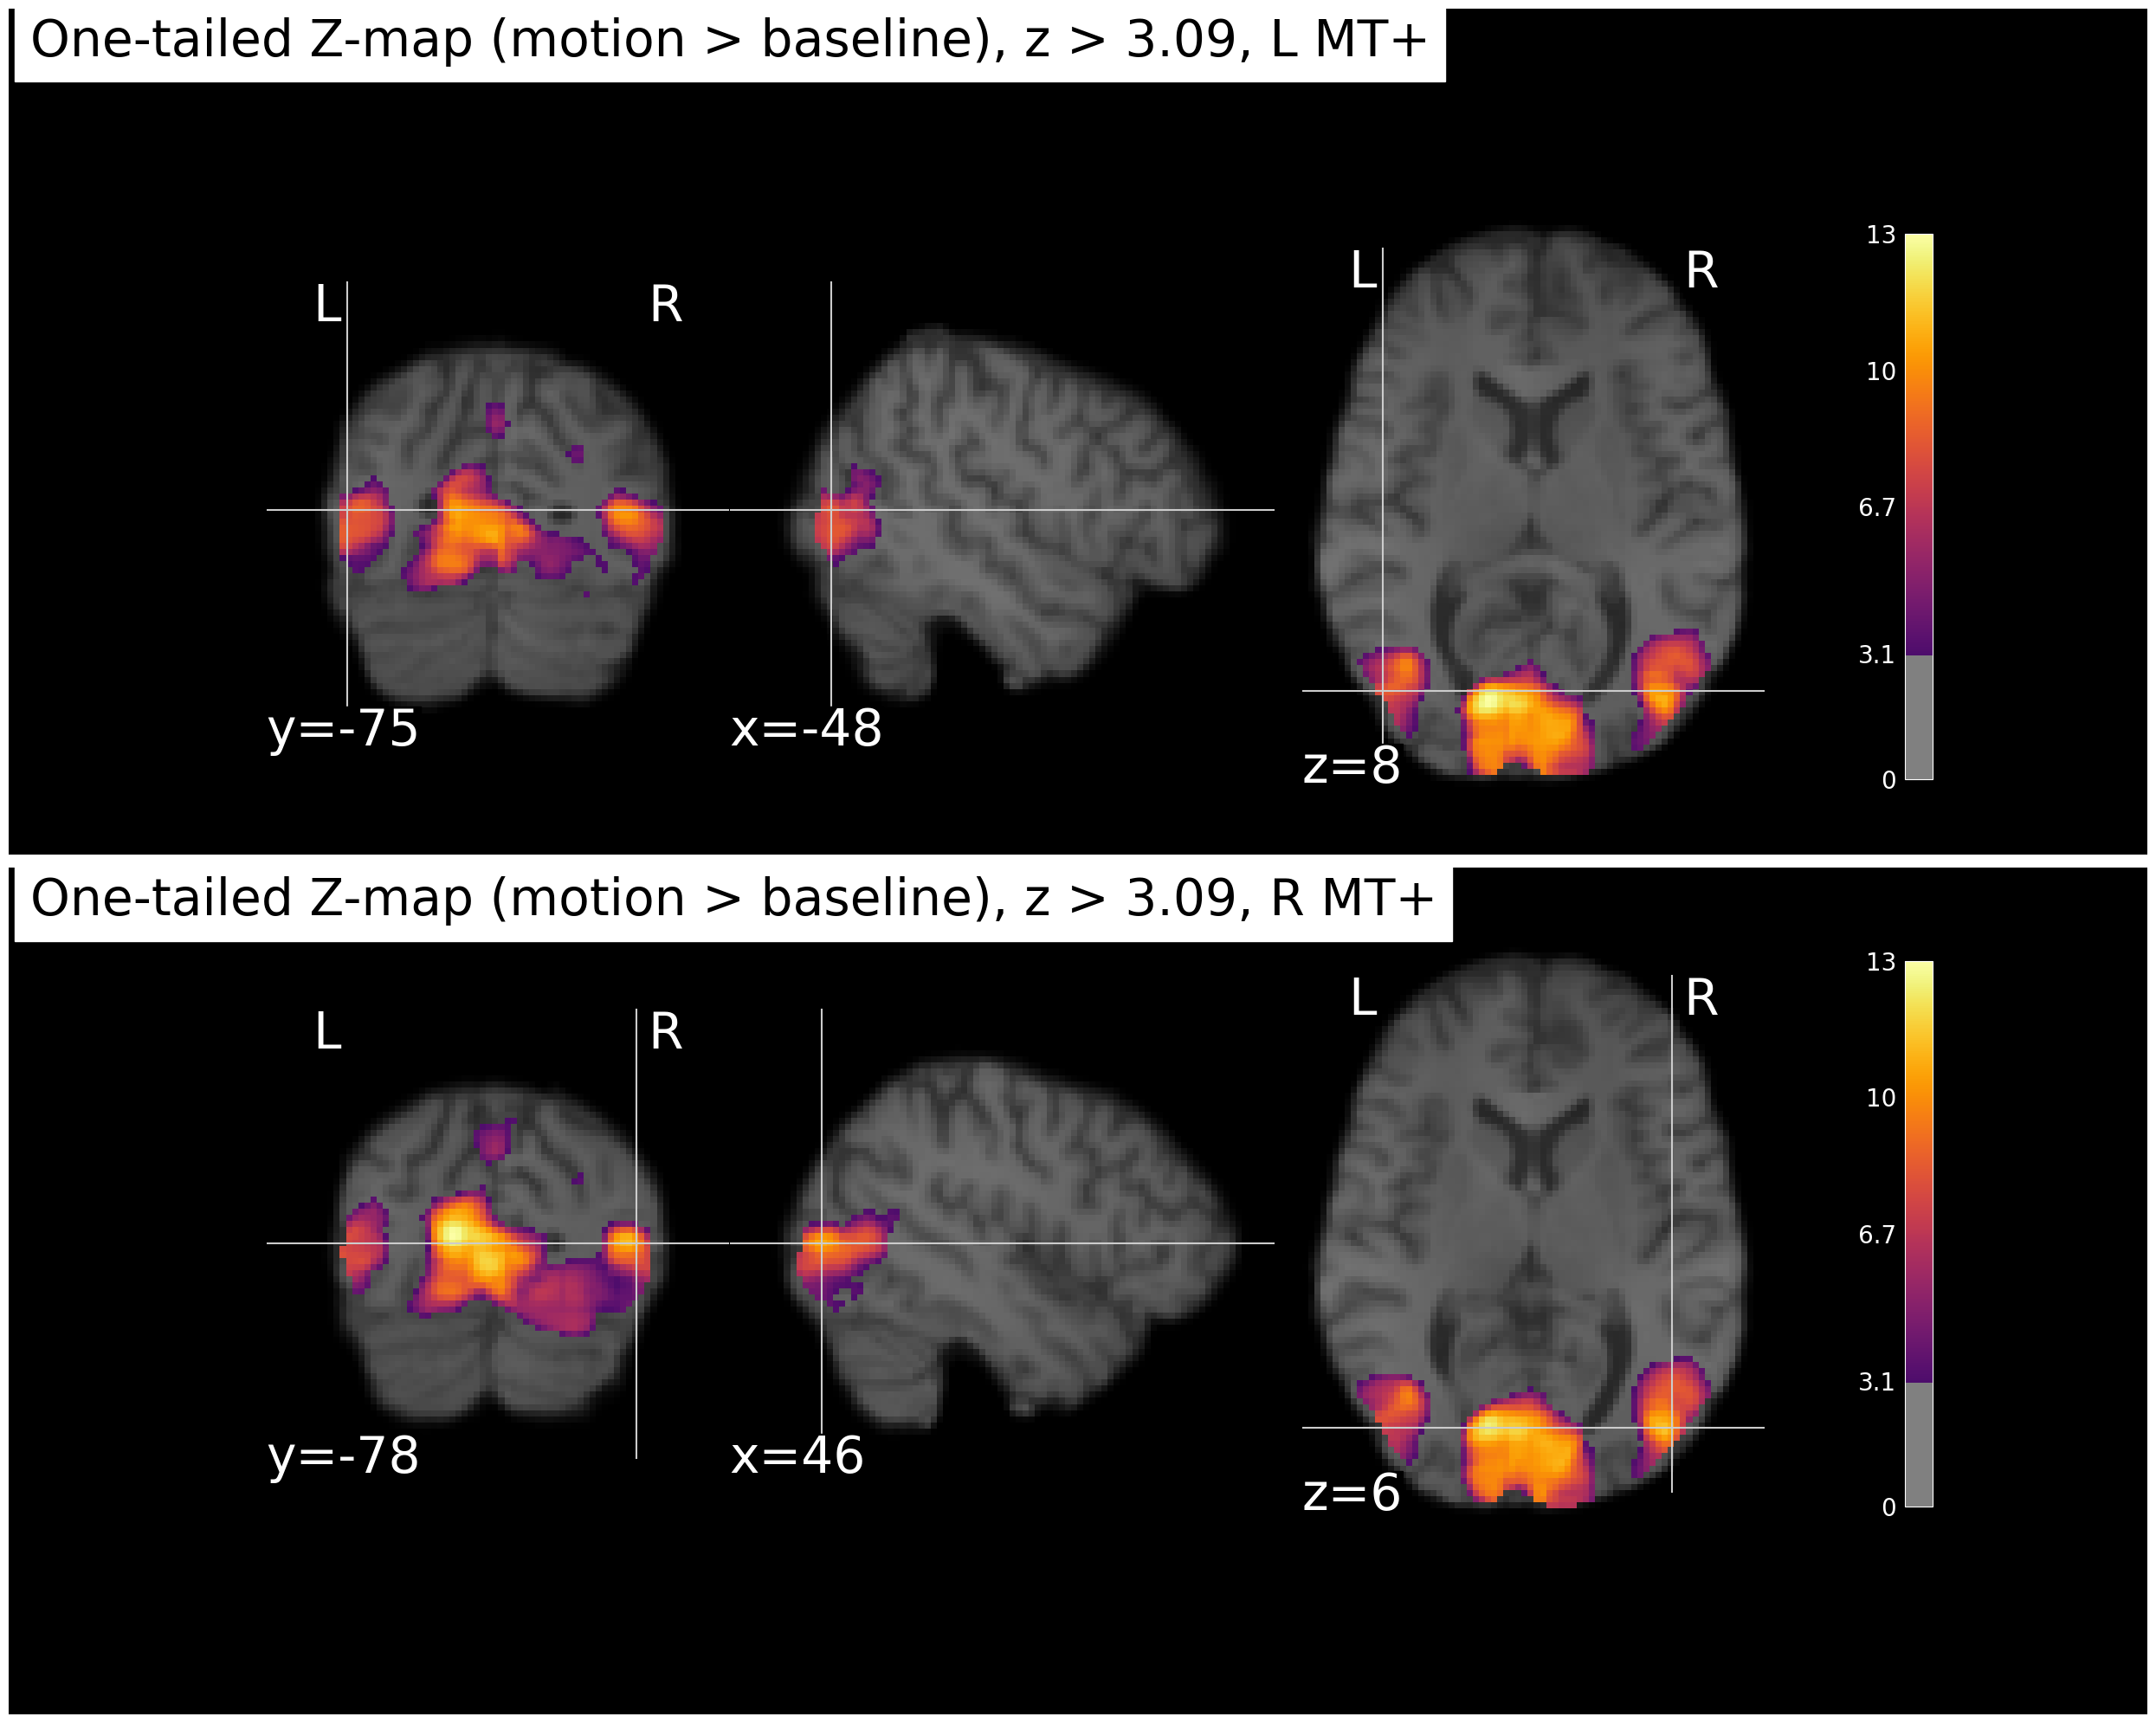

In [20]:
# Call the function with the z-map
plot_mt_maps(z_map_motion)

We can see that there is strong activation in both left and right MT+, as expected. The activation is a bit more extensive in the right hemisphere for this particular subject, but that can vary across individuals. There's also a large area. of activation medially, possibly corresponding to the another motion-sensitive area, V3A.

### Multiple Comparisons Correction

Recall that we fit the design matrix to the time series from each voxel of the fMRI scan using the general linear model (GLM). There are thousands or even millions of voxels in a typical fMRI scan, as we can see by computing the product (multplying) the dimensions of the `z_map_motion` image:

```python
# compute the number of voxels in z_map_motion
n_voxels = np.prod(z_map_motion.shape)
print(f"Number of voxels in z_map_motion: {n_voxels}")
```
`Number of voxels in z_map_motion: 10485760`


So we've performed over ten million statistical tests! This raises an important issue known as the multiple comparisons problem. When we apply a statistical threshold such as `p < .001` to the results from a single voxel, we are estimating that there is only a 1/1000 chance of incorrectly rejecting the null hypothesis (i.e., identifying that voxel as significantly active when it is not). However, we are performing far more than 1000 tests simultaneously, as we have over ten million voxels in this example. This means that a simple threshold of `p < .001` is not sufficient to control the overall error rate across all voxels. Indeed, if you look closely at the image above you can see small areas of purple (which are the weakest "significant" activations that just barely pass the threshold) scattered throughout the brain, many of which are likely to be false positives.

When viewing the results of voxel-wise statistical tests across the entire brain, it is important to apply *multiple comparisons correction* methods to control the overall error rate, often refrred to as the *family-wise error rate*. There are many different ways to do this. Common methods include Bonferroni correction, False Discovery Rate (FDR), and cluster-based thresholding. These methods help to reduce the likelihood of false positives and improve the reliability of the results.

#### Bonferroni Correction

Bonferroni correction is a straightforward method for controlling the family-wise error rate when performing multiple statistical tests. The basic idea is to adjust the significance threshold for each individual test based on the total number of tests being performed. Specifically, if you want to maintain an overall significance level of α (e.g., 0.05) across all tests, you would divide α by the number of tests (N) to obtain a new, more stringent threshold for each individual test: α_corrected = α / N. 

In the present data set, we have over ten million voxels, so if we wanted to maintain an overall significance level of 0.05 across all voxels, we would need to use a corrected threshold of 0.05 / 10,485,760 ≈ 4.77e-09 for each individual voxel. This is a very stringent threshold, and it may result in very few voxels being identified as significantly active. Thus Bonferroni correction is often considered *too conservative* for fMRI data, where the number of tests (voxels) is very large and the tests are not independent due to spatial correlations in the data.

/var/folders/nq/chbqhzjx5hb6hfjx708rh2_40000gn/T/ipykernel_43853/519649290.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


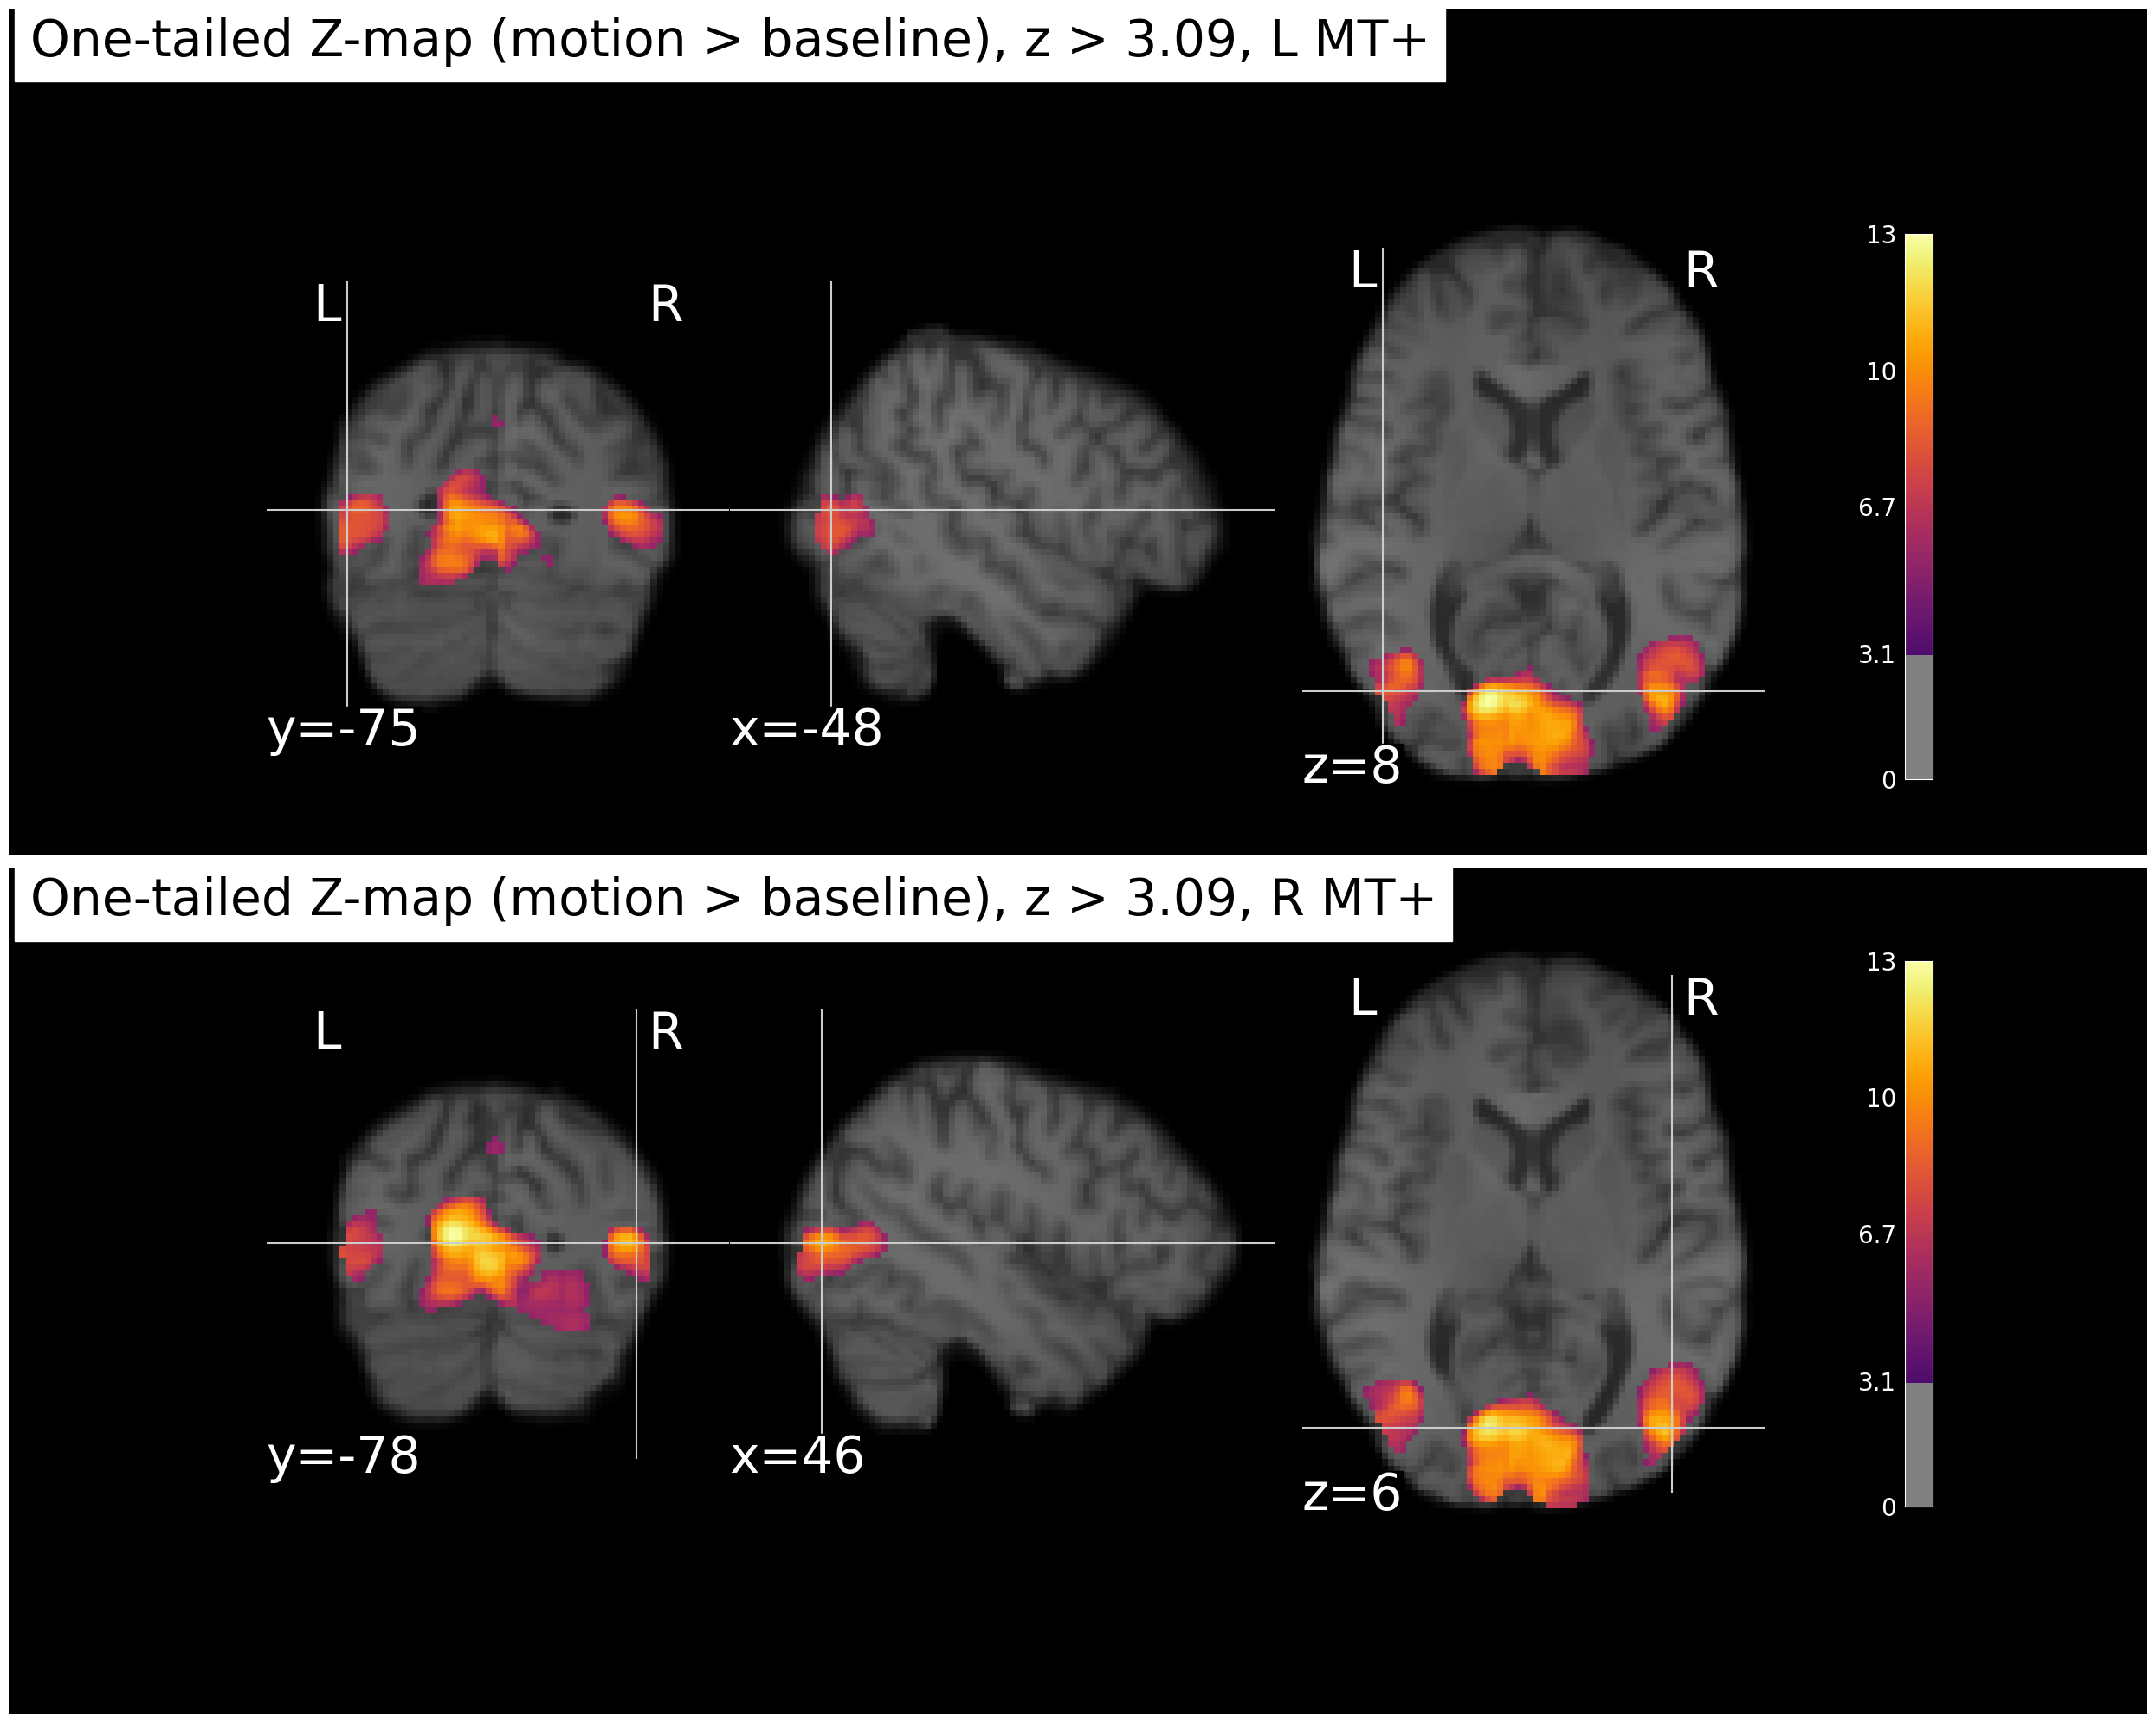

In [21]:
# apply Bonferroni correction to the z-map

thresholded_map, threshold = threshold_stats_img(z_map_motion, 
                                                 alpha=0.05, 
                                                 height_control='bonferroni'
                                                 )     

plot_mt_maps(thresholded_map)

#### False Discovery Rate (FDR)

The False Discovery Rate (FDR) is a statistical method used to correct for multiple comparisons when performing voxel-wise analyses in fMRI data. It was first described by [Benjamini and Hochberg (1995)](https://www.jstor.org/stable/2346101) and was introduced to the fMRI community by [Genovese, Lazar, and Nichols (2002)](https://doi.org/10.1006/nimg.2001.1037). FDR has since become a widely used approach in neuroimaging research.

Unlike Bonferroni correction, which controls the family-wise error rate (the probability of making at least one Type I error across all tests), FDR controls the expected proportion of false positives among the voxels that are declared significant. This makes FDR less conservative than Bonferroni correction, allowing for more true positives to be detected while still controlling the rate of false discoveries.

/var/folders/nq/chbqhzjx5hb6hfjx708rh2_40000gn/T/ipykernel_43853/519649290.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


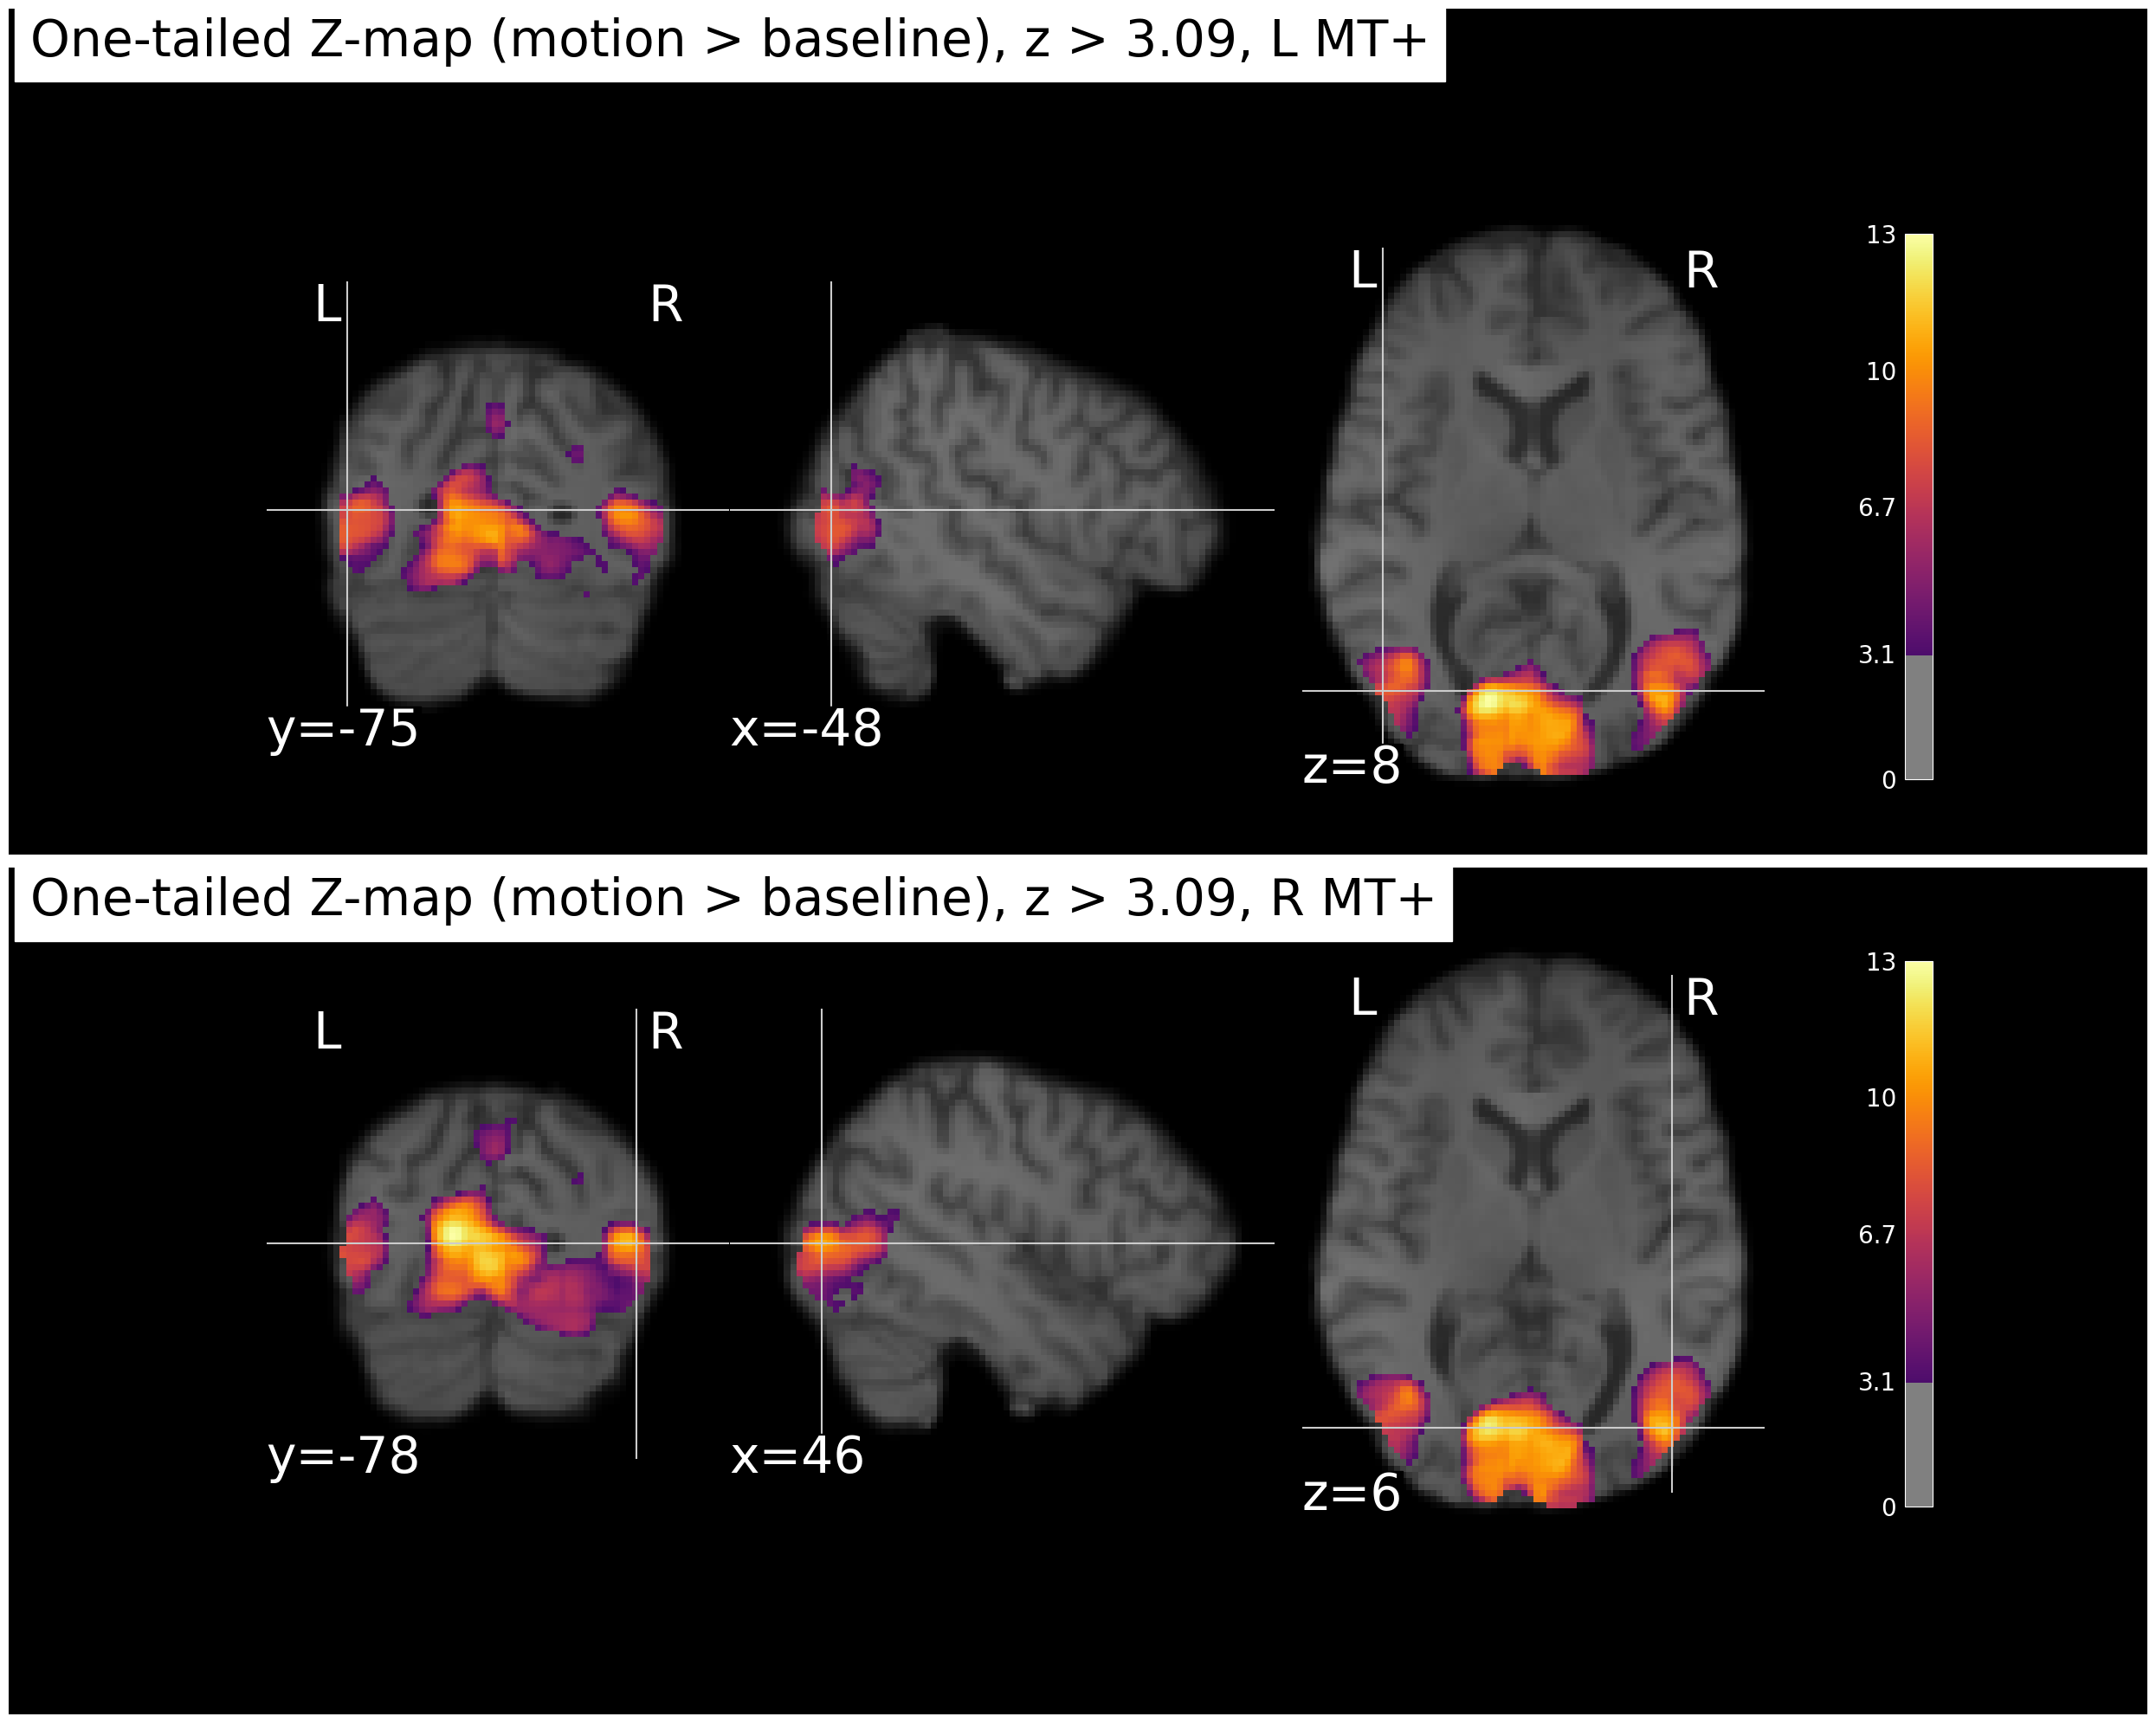

In [22]:
# apply FDR correction to the z-map
thresholded_map_fdr, threshold = threshold_stats_img(z_map_motion, 
                                                 alpha=0.05, 
                                                 height_control='fdr'
                                                 )     

plot_mt_maps(thresholded_map_fdr)

### View a table of the results

While the thresholded statistical maps above may look pretty, we often want to report the results in a more systamtic way, such as in a table. This makes it easier to compare results between different studies rather than "eyeballing" similarities. Obviously, however, we don't want to make a table listing details of every voxel that survived multiple comparisons correction! Instead, it's useful to apply clustering to find groups of contigous (adjacent) voxels all above threshold, which could be inferred to represent a specific functional area in the brain. 

`Nilearn` provides a convenient function to extract and view clusters of activation from the statistical maps. This function identifies clusters of contiguous voxels that exceed a specified statistical threshold *and* exceed a specified cluster size. This is an alternative approach to multiple comparisons correction, which estimates the probability that a cluster (a set of voxels all touching each other and all above the *z* threshold) of a certain size would be observed by chance. This is based on the recognition that it's less probable that 1000 voxels all `z > 3.09`  would be clutered together by chance, than 10 voxels all above that threshold. 

However, the implementation of this in `Nilearn` is relatively simple, in that the user must provide a cluster size threshold. This makes it somewhat arbitrary as to how the clusters are determined, rather than defining the cluster size threshold in a principled mathematical way. Other software package use methods such as Gaussian random field theory or nonparametric permutation to estimate cluster thresholds in principled ways.

Regardless, we can use this function to extract clusters from our thresholded *z* map and view them in a table, below.

In [23]:
# view a table of the results with FDR correction
clusters_table = get_clusters_table(
    z_map_motion,
    stat_threshold=z_thresh,
    cluster_threshold=1000,  # minimum cluster size in voxels
    two_sided=False,       # one-tailed test
)

clusters_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-14.0,-80.0,10.0,13.463215,74968
1,1a,-6.0,-80.0,8.0,12.309165,
2,1b,-2.0,-80.0,0.0,12.206151,
3,1c,44.0,-80.0,6.0,11.553452,
4,2,-40.0,-68.0,6.0,9.743365,11280
5,2a,-50.0,-76.0,-2.0,8.662803,
6,2b,-42.0,-66.0,20.0,7.486142,
7,2c,-58.0,-56.0,12.0,6.136423,


The table shows that the clustering algorithm only identified two distinct clusters. In the maps above, it looked like there were at least three distinct areas of activation (left MT+, right MT+, and medial occipital cortex). However, it sometimes happens in fMRI analysis that some areas of activation "bleed into" others. That is likely the case here — the medial cluster is probably connected to one of the MT+ clusters. Note that each cluster has a number of sub-clusters listed (e.g., `1a`, `1b`, etc.) within this larger cluster. These represent smaller peaks within the larger connected blob of significatnt voxels. Based on our simple explanation of MNI coordinates above, we can infer that cluster 1 is probably located medially (since the *x* values are small numbers, close to the centre of the brain), while cluster 2 is probably the left MT+ (since its *x* coordinates are negative). Cluster `1c` has an *x* value of 44 which suggests it may correspond to right MT+. However, without anatomicl labels it's a bit hard to interpret this table. 

### Get Anatomical Labels for Clusters

We can use the `atlasquery` Python library to get anatomical labels for the clusters identified above. This library allows us to query various brain atlases to obtain anatomical labels based on MNI coordinates. We will use the Harvard-Oxford atlas, which is a commonly used anatomical atlas in neuroimaging.

In [24]:
# Get anatomical labels for clusters using atlas
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import coord_transform

# Load Harvard-Oxford cortical atlas
ho_atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Get clusters table
clusters_table = get_clusters_table(
    z_map_motion,
    stat_threshold=z_thresh,
    cluster_threshold=1000,  # minimum cluster size in voxels     
    two_sided=False,       # one-tailed test
)

# Get atlas image data - ho_atlas.maps is already a Nifti1Image object
atlas_img = ho_atlas.maps
atlas_data = atlas_img.get_fdata()
atlas_affine = atlas_img.affine

# Map cluster peak coordinates to anatomical labels
anatomical_labels = []
for _, row in clusters_table.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    
    # Convert MNI coordinates (mm) to voxel indices in atlas space
    i, j, k = coord_transform(x, y, z, np.linalg.inv(atlas_affine))
    i, j, k = int(np.round(i)), int(np.round(j)), int(np.round(k))
    
    # Check bounds and get label
    if (0 <= i < atlas_data.shape[0] and 
        0 <= j < atlas_data.shape[1] and 
        0 <= k < atlas_data.shape[2]):
        label_index = int(atlas_data[i, j, k])
        if label_index > 0 and label_index < len(ho_atlas.labels):
            anatomical_labels.append(ho_atlas.labels[label_index])
        else:
            anatomical_labels.append('Unknown')
    else:
        anatomical_labels.append('Out of bounds')

# Add anatomical labels to clusters table
clusters_table['Anatomical Label'] = anatomical_labels
clusters_table


[fetch_atlas_harvard_oxford] Dataset found in /Users/aaron/nilearn_data/fsl


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Anatomical Label
0,1,-14.0,-80.0,10.0,13.463215,74968,Intracalcarine Cortex
1,1a,-6.0,-80.0,8.0,12.309165,,Intracalcarine Cortex
2,1b,-2.0,-80.0,0.0,12.206151,,Lingual Gyrus
3,1c,44.0,-80.0,6.0,11.553452,,"Lateral Occipital Cortex, inferior division"
4,2,-40.0,-68.0,6.0,9.743365,11280,"Lateral Occipital Cortex, inferior division"
5,2a,-50.0,-76.0,-2.0,8.662803,,"Lateral Occipital Cortex, inferior division"
6,2b,-42.0,-66.0,20.0,7.486142,,"Lateral Occipital Cortex, superior division"
7,2c,-58.0,-56.0,12.0,6.136423,,"Middle Temporal Gyrus, temporooccipital part"


The last column of the table now contains anatomical labels. We can see from these labels that the largest cluster is centered in the intracalcarine cortex. This is the large blob we observed earlier in the middle of the occipital lobe, likely corresponding to area V3A. However, as we guessed earlier, sub-cluster `1c` is located in the right lateral occipital cortex, which likely corresponds to right MT+. Cluster 2 is located in the left lateral occipital cortex, corresponding to left MT+. Thus, our analysis has successfully identified both left and right MT+ as being significantly more active during blocks of moving dots compared to static dots, as expected based on prior literature.